In [1]:
import os,numpy as np, matplotlib.pyplot as plt,pandas as pd

In [13]:
import torch.optim as optim
import torch
from torch.autograd import Variable
import time
import torch
import torch.nn as nn
# from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np
from HeartCepTorch import MFCC_Gen,Network
import torch.nn.functional as F
import torch.nn.init as init
from torchsummary import summary
def to_numpy(x):
    return x.cpu().detach().numpy()

In [37]:
model = Network(2,0)
mfcc_gen = MFCC_Gen(fs=1000,filters=64)

In [26]:
class WHOLE_MODEL(nn.Module):
    def __init__(self,kernel_size = 81,filters = 26,fs=1000,winlen=0.025,winstep=0.01,dimension=1):
        super(WHOLE_MODEL,self).__init__()
        self.mfcc = MFCC_Gen(fs=1000,filters=64)
        self.classifier = Network(2,0)
        for x in self.mfcc.gamma.named_parameters():
            x[1].requires_grad = True
    def forward(self,x):
        x = self.mfcc(x)
        x = x.transpose(2,1)
        x = x.unsqueeze(1)
        x = self.classifier(x)
        return x

In [27]:
model = WHOLE_MODEL()

In [8]:
path = "../../Heartnet_Results/logs/gammatone_torch_layer/"
fold = 'a_bcdEf learnable_2020-03-04 17.19.23.260152'

In [14]:
weight = sorted(os.listdir(os.path.join(path,fold,'weights')))[-1]

In [29]:
model.load_state_dict(torch.load(os.path.join(path,fold,'weights',weight)))

<All keys matched successfully>

In [36]:
int(weight.split('-',maxsplit=1)[0].split('.')[-1])

154

In [7]:
fc = mfcc_gen.gamma.fc

In [31]:
optimizer = optim.Adam(model.parameters(), lr= .01)
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()
start_epoch = 0
lr_schedule = optim.lr_scheduler.ExponentialLR(optimizer,0.986)
# wow= []
# for i in range(400):
#     optimizer.step()
#     wow.append(optimizer.param_groups[0]['lr'])
#     sh.step()
# plt.plot(wow)
# print(wow[-1])

In [43]:
model.cuda()
model.train()
for i in range(100):
    optimizer.zero_grad()
    loss = torch.from_numpy(np.array(100.198).astype(np.float32)).cuda()
    loss.requires_grad = True
    loss.backward()
    optimizer.step()

In [2]:
import whole_new_model,importlib
whole_new_model = importlib.reload(whole_new_model)
from whole_new_model import WHOLE_NEW_MODEL

In [4]:
model = WHOLE_NEW_MODEL()

In [5]:
summary(model.cuda(),(1,2500))

OK
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2420]           5,312
       BatchNorm1d-2             [-1, 64, 2420]             192
            Conv1d-3              [-1, 64, 240]         102,400
       BatchNorm1d-4              [-1, 64, 240]             192
            Conv2d-5          [-1, 16, 244, 65]             128
       BatchNorm2d-6          [-1, 16, 244, 65]              48
            Conv2d-7          [-1, 32, 242, 63]           4,672
       BatchNorm2d-8          [-1, 32, 242, 63]              96
         Dropout2d-9          [-1, 32, 242, 63]               0
           Conv2d-10          [-1, 32, 244, 65]           9,280
      BatchNorm2d-11          [-1, 32, 244, 65]              96
        Dropout2d-12          [-1, 32, 244, 65]               0
           Conv2d-13          [-1, 64, 122, 32]          18,560
      BatchNorm2d-14          [-1, 6

In [3]:
from torch.nn.parameter import Parameter
from HeartCepTorch import Conv_Gammatone_coeff
class Branch(nn.Module):
    def __init__(self,c_in, c_out, kernel_size=5,stride=1,dropout = 0.5):
        super(Branch, self).__init__()
        self.conv1 = nn.Conv1d(c_in, c_out*2, kernel_size=kernel_size,stride=stride)
        self.bn1 = nn.BatchNorm1d(c_out*2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(c_out*2, c_out, kernel_size=kernel_size,stride=stride)
        self.bn2 = nn.BatchNorm1d(c_out)
        self.pool = nn.MaxPool1d(2)
    def forward(self, x):
        x = self.drop(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(x)
        x = self.drop(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(x)
        return x
class Net(nn.Module):
    def __init__(self,filters=64,kernel_size=81,fs=1000):
        super(Net,self).__init__()
        wow = Conv_Gammatone_coeff(1,filters,kernel_size,fs)
        self.filterbank = nn.ModuleList()
        for i in range(filters):
            conv = nn.Conv1d(1,1,kernel_size=kernel_size)
            conv.weight = Parameter(wow.weight[i:i+1])
            self.filterbank.append(conv)
        self.branches = nn.ModuleList()
        for i in range(filters):
            branch = Branch(1,4)
            self.branches.append(branch)
        self.dense = nn.Linear(4*602*filters,20)
        self.cls = nn.Linear(20,2)
        self.relu = nn.ReLU()
        self.soft = nn.Softmax()
    def forward(self,x):
        x = [c(x) for c in self.filterbank]
        x = [c(xx) for (xx,c) in zip(x,self.branches)]
        x = torch.cat(x,dim=1)
        x = x.view(x.size(0),-1)
        x = self.relu(self.dense(x))
        x = self.soft(self.cls(x))
        return x
model = Net()

In [ ]:
# from torchviz import make_dot

# out = model(torch.randn(1,1,2500).cuda())
# make_dot(out,params = dict(model.named_parameters()))

In [5]:
summary(model.cuda(), (1,2500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 1, 2420]              83
            Conv1d-2              [-1, 1, 2420]              83
            Conv1d-3              [-1, 1, 2420]              83
            Conv1d-4              [-1, 1, 2420]              83
            Conv1d-5              [-1, 1, 2420]              83
            Conv1d-6              [-1, 1, 2420]              83
            Conv1d-7              [-1, 1, 2420]              83
            Conv1d-8              [-1, 1, 2420]              83
            Conv1d-9              [-1, 1, 2420]              83
           Conv1d-10              [-1, 1, 2420]              83
           Conv1d-11              [-1, 1, 2420]              83
           Conv1d-12              [-1, 1, 2420]              83
           Conv1d-13              [-1, 1, 2420]              83
           Conv1d-14              [-1, 

/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
path = '/media/mhealthra2/Data/heart_sound/Heartnet_Results/logs/gammatone_torch_layer/fold0_noFIR dbt 64 HNET_2020-05-17 17.56.06.569274/weights/'
weights = os.listdir(path)
len(weights)

138

In [31]:
model.load_state_dict(torch.load(path+weights[5]))

<All keys matched successfully>

In [26]:
key = "filterbank.{0}.weight"

In [28]:
wow['filterbank.0.weight']

tensor([[[ 0.0252,  0.0252,  0.0162,  0.0122,  0.0136,  0.0125,  0.0211,
           0.0261,  0.0185,  0.0155,  0.0204,  0.0192,  0.0167,  0.0153,
           0.0087,  0.0073,  0.0056,  0.0007, -0.0059, -0.0097, -0.0126,
          -0.0217, -0.0205, -0.0156, -0.0168, -0.0107, -0.0061, -0.0089,
          -0.0099, -0.0099, -0.0069, -0.0064, -0.0092, -0.0016,  0.0052,
           0.0047,  0.0040,  0.0060,  0.0150,  0.0198,  0.0092,  0.0015,
           0.0045, -0.0002, -0.0067, -0.0050, -0.0099, -0.0138, -0.0015,
           0.0016, -0.0163, -0.0122,  0.0058, -0.0077, -0.0193, -0.0062,
          -0.0057, -0.0189, -0.0207, -0.0075, -0.0017, -0.0063, -0.0039,
           0.0029,  0.0008,  0.0049,  0.0133,  0.0122,  0.0124,  0.0172,
           0.0154,  0.0120,  0.0155,  0.0300,  0.0364,  0.0304,  0.0319,
           0.0417,  0.0352,  0.0099,  0.0048]]], device='cuda:0')

weights.0053-acc_0.7331-macc_0.8059.pt


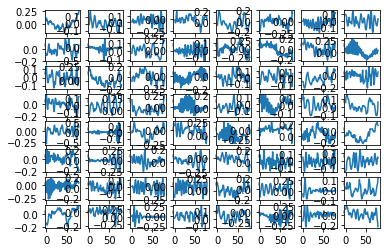

In [43]:
idx = 53
print(weights[idx])
model.load_state_dict(torch.load(path+weights[idx]))
for i in range(64):
#     plt.figure(figsize=(5,5))
    w = model.filterbank[i].weight  
    plt.subplot(8,8,i+1)
    plt.plot(to_numpy(w).squeeze().squeeze())

In [49]:
path = '/media/mhealthra2/Data/heart_sound/Heartnet_Results/logs/gammatone_torch_layer/fold0_noFIR dbt 64 HNET_2020-05-17 17.56.06.569274/weights/'
weights = os.listdir(path)
wow = dict(torch.load(path+weights[53]))
gamma_weight = torch.cat([wow['filterbank.{}.weight'.format(i)] for i in range(64)])
    

torch.Size([64, 1, 81])

In [44]:
model.filterbank[0].weight.shape

torch.Size([1, 1, 81])

In [ ]:
torch.cat

In [ ]:
a = 5